<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/MVP_Bert_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip install tensorflow-text

In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
import tensorflow_hub as hub
import tensorflow_text as text

In [152]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/McDonald_s_Reviews.csv"

# Lê o arquivo
df = pd.read_csv(url, delimiter=',', encoding='latin-1')
df = df.head(1000)

In [153]:
rat=df.rating.value_counts()
rat

5 stars    283
1 star     279
3 stars    176
4 stars    164
2 stars     98
Name: rating, dtype: int64

In [154]:
import matplotlib.pyplot as plt

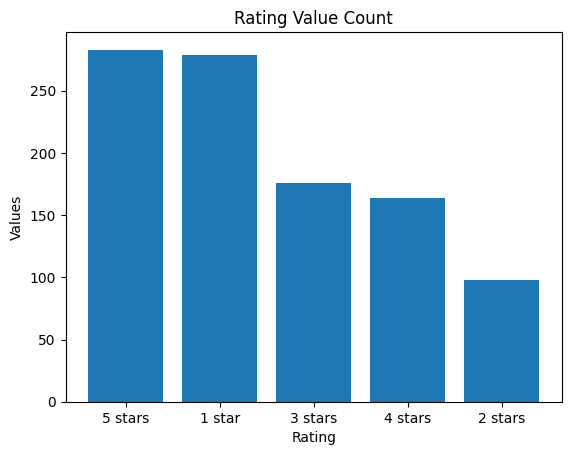

In [155]:
fig, ax = plt.subplots()
ax.bar(rat.index, rat.values)

# Set labels and title
ax.set_xlabel('Rating')
ax.set_ylabel('Values')
ax.set_title('Rating Value Count')

# Display the plot
plt.show()

In [156]:
import re
df["rating"] = df["rating"].str.extract(r"(\d+)", expand=False).astype(int)

In [157]:
mapping={1:0,2:0,3:None,4:1,5:1}
df['rating_bin']=df.rating.map(mapping)
df=df.dropna(subset='rating_bin')

In [177]:
df.head(10)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,rating_bin
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1,0.0
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4,1.0
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1,0.0
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was customer s...,5,1.0
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1,0.0
5,6,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 weeks ago,I work for door dash and they locked us all ou...,1,0.0
6,7,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,If I could give this location a zero on custo...,1,0.0
7,8,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a year ago,Came in and ordered a Large coffee w/no ice. T...,1,0.0
8,9,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Went thru drive thru. Ordered. Getting home no...,1,0.0
9,10,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,"I'm not really a huge fan of fast food, but I ...",4,1.0


In [159]:
df["review"] = df["review"].str.encode("ascii", "ignore").str.decode("utf-8")

In [160]:
df_Mult = df[["review", "rating"]]
df_Bin = df[["review", "rating_bin"]]

In [161]:
#Separa conjunto de treino e teste para a classificação multiclasse
X_train, X_test, y_train, y_test = train_test_split(df_Mult.review,df_Mult.rating,test_size=0.2)

In [162]:
X_train.shape

(659,)

In [163]:
X_test.shape

(165,)

In [164]:
print(df_Bin)

                                                review  rating_bin
0    Why does it look like someone spit on my food?...         0.0
1    It'd McDonalds. It is what it is as far as the...         1.0
2    Made a mobile order got to the speaker and che...         0.0
3    My mc. Crispy chicken sandwich was  customer s...         1.0
4    I repeat my order 3 times in the drive thru, a...         0.0
..                                                 ...         ...
995  This place is the one in front of the Lehigh V...         0.0
996  The service at the drive in was terrible.i sat...         0.0
997  Their cheeseburger costs more than a double ch...         0.0
998                Good service. Everything good here.         1.0
999  Seriously who forgets to put everything on a b...         0.0

[824 rows x 2 columns]


In [165]:
#Separa conjunto de treino e teste para a classificação binária
X_Btrain, X_Btest, y_Btrain, y_Btest = train_test_split(df_Bin.review,df_Bin.rating_bin,test_size=0.2)

In [147]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [166]:
def get_sentense_embeding(sentences):
    preprocesed_text=bert_preprocess(sentences)
    return bert_encoder(preprocesed_text)['pooled_output']

get_sentense_embeding([
    df.review[5],df.review[1]
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8367605 , -0.6208267 , -0.9702623 , ..., -0.8431032 ,
        -0.66128534,  0.9062021 ],
       [-0.6168058 , -0.31054088, -0.91254514, ..., -0.7911302 ,
        -0.5656402 ,  0.80636483]], dtype=float32)>

In [171]:
#O modelo abaixo é adequado para classificação binária
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)
model_bin=tf.keras.Model(inputs=[text_input],outputs=[l])


#Alterado para considerar as 5 classses:
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(5,activation='softmax',name='output')(l)
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [172]:
METRICS=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

METRICS_BIN=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)
model_bin.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS_BIN)

In [173]:
#Converta os rótulos de classe em codificação one-hot
y_train_adjusted = y_train - 1
y_train_one_hot = tf.keras.utils.to_categorical(y_train_adjusted, num_classes=5)

model.fit(X_train,y_train_one_hot,epochs=5)

Epoch 1/5
21/21 [==============================] - 9s 296ms/step - loss: 1.3165 - accuracy: 0.4279 - precision: 0.4286 - recall: 0.1502
Epoch 2/5
21/21 [==============================] - 6s 292ms/step - loss: 1.2507 - accuracy: 0.4628 - precision: 0.5351 - recall: 0.1851
Epoch 3/5
21/21 [==============================] - 6s 296ms/step - loss: 1.2441 - accuracy: 0.4507 - precision: 0.5328 - recall: 0.1973
Epoch 4/5
21/21 [==============================] - 6s 295ms/step - loss: 1.2169 - accuracy: 0.4886 - precision: 0.5654 - recall: 0.2231
Epoch 5/5
21/21 [==============================] - 6s 296ms/step - loss: 1.2072 - accuracy: 0.4977 - precision: 0.5945 - recall: 0.2625


In [170]:
model_bin.fit(X_Btrain,y_Btrain,epochs=10)

Epoch 1/10
21/21 [==============================] - 6s 290ms/step - loss: 0.5663 - accuracy: 0.7147 - precision: 0.7111 - recall: 0.7949
Epoch 2/10
21/21 [==============================] - 6s 295ms/step - loss: 0.5610 - accuracy: 0.7299 - precision: 0.7472 - recall: 0.7556
Epoch 3/10
21/21 [==============================] - 6s 293ms/step - loss: 0.5441 - accuracy: 0.7329 - precision: 0.7528 - recall: 0.7528
Epoch 4/10
21/21 [==============================] - 6s 299ms/step - loss: 0.5347 - accuracy: 0.7587 - precision: 0.7669 - recall: 0.7949
Epoch 5/10
21/21 [==============================] - 6s 295ms/step - loss: 0.5212 - accuracy: 0.7618 - precision: 0.7653 - recall: 0.8062
Epoch 6/10
21/21 [==============================] - 6s 298ms/step - loss: 0.5276 - accuracy: 0.7481 - precision: 0.7527 - recall: 0.7949
Epoch 7/10
21/21 [==============================] - 6s 296ms/step - loss: 0.5205 - accuracy: 0.7405 - precision: 0.7534 - recall: 0.7725
Epoch 8/10
21/21 [=======================

In [174]:
#Avaliação do modelo multiclasse com a base de teste
y_test_adjusted = y_test - 1
y_test_one_hot = tf.keras.utils.to_categorical(y_test_adjusted, num_classes=5)

model.evaluate(X_test,y_test_one_hot)

6/6 [==============================] - 3s 250ms/step - loss: 1.1676 - accuracy: 0.5333 - precision: 0.8889 - recall: 0.1939


[1.1675846576690674,
 0.5333333611488342,
 0.8888888955116272,
 0.19393938779830933]

In [178]:
print(X_Btest)

613                                           Excellent 
778                                           Excellent 
302    Just isn't good food. Supersize Me just turned...
714                                           Excellent 
727                                                  sad
                             ...                        
116    All that I had ordered was two McDoubles and l...
56     I go here all the time. Great staff.. NVR get ...
157    Every time I go here they are always missing f...
299    Fries tasted like they were cooked in grease f...
360      Manager was rude.. staff is very unprofessional
Name: review, Length: 165, dtype: object


In [180]:
print(y_Btest)

613    1.0
778    1.0
302    0.0
714    1.0
727    0.0
      ... 
116    0.0
56     1.0
157    0.0
299    0.0
360    0.0
Name: rating_bin, Length: 165, dtype: float64
613    1.0
778    1.0
302    0.0
714    1.0
727    0.0
      ... 
116    0.0
56     1.0
157    0.0
299    0.0
360    0.0
Name: rating_bin, Length: 165, dtype: float64


In [181]:
model_bin.evaluate(X_Btest,y_Btest)

6/6 [==============================] - 2s 246ms/step - loss: 0.7875 - accuracy: 0.3515 - precision: 0.2647 - recall: 0.0989


[0.7874606847763062,
 0.35151514410972595,
 0.2647058963775635,
 0.09890110045671463]

In [185]:
y_Bpred=model.predict(X_Btest)
y_Bpred=y_Bpred.flatten()

6/6 [==============================] - 2s 304ms/step


In [187]:
y_Bpred.shape

(825,)

In [188]:
y_pred_classes = np.argmax(y_Bpred, axis=0)
print(y_pred_classes)

95


In [194]:
y_Bpred=np.where(y_Bpred>0.5,1,0)
#y_Bpred

In [192]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_Btest,y_pred_classes)

TypeError: ignored

Text(50.722222222222214, 0.5, 'Truth')

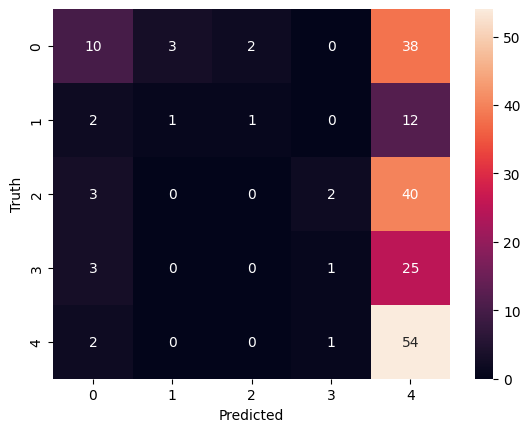

In [69]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")

In [26]:
print(classification_report(y_test,y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00      1903
           2       0.09      0.09      0.09       638
           3       0.15      0.13      0.14       903
           4       0.18      0.35      0.24      1154
           5       0.00      0.00      0.00      2082

    accuracy                           0.09      6680
   macro avg       0.07      0.10      0.08      6680
weighted avg       0.06      0.09      0.07      6680



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [27]:
reviews=[df.review[0],df.review[1]

]
model.predict(reviews)

1/1 [==============================] - 1s 744ms/step


array([[0.7819445 , 0.07834104, 0.05455459, 0.03658522, 0.04857462],
       [0.0531323 , 0.0550392 , 0.12272887, 0.45600456, 0.31309515]],
      dtype=float32)